In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import shutil
import os
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from tqdm import tqdm
import multiprocessing as mp
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pickle

In [3]:
shutil.copytree('drive/MyDrive/JHU_Courses/Deep_Learning/Project/frames_1fps_resize_zip', 'frames_1fps_resize_zip')

'frames_1fps_resize_zip'

In [4]:
cd frames_1fps_resize_zip

/content/frames_1fps_resize_zip


In [5]:
!unzip frames-1fps-resize.zip

Streaming output truncated to the last 5000 lines.
  inflating: frames-1fps-resize/video79/video79-1123.jpg  
  inflating: frames-1fps-resize/video79/video79-1124.jpg  
  inflating: frames-1fps-resize/video79/video79-1125.jpg  
  inflating: frames-1fps-resize/video79/video79-1126.jpg  
  inflating: frames-1fps-resize/video79/video79-1127.jpg  
  inflating: frames-1fps-resize/video79/video79-1128.jpg  
  inflating: frames-1fps-resize/video79/video79-1129.jpg  
  inflating: frames-1fps-resize/video79/video79-113.jpg  
  inflating: frames-1fps-resize/video79/video79-1130.jpg  
  inflating: frames-1fps-resize/video79/video79-1131.jpg  
  inflating: frames-1fps-resize/video79/video79-1132.jpg  
  inflating: frames-1fps-resize/video79/video79-1133.jpg  
  inflating: frames-1fps-resize/video79/video79-1134.jpg  
  inflating: frames-1fps-resize/video79/video79-1135.jpg  
  inflating: frames-1fps-resize/video79/video79-1136.jpg  
  inflating: frames-1fps-resize/video79/video79-1137.jpg  
  infl

In [6]:
cd ..

/content


In [7]:
project_path = "drive/MyDrive/JHU_Courses/Deep_Learning/Project"

In [8]:
# get paths and labels
img_dir = 'frames_1fps_resize_zip/frames-1fps-resize/'
tool_dir = project_path+'/Dataset/cholec80/tool_annotations'
phase_dir = project_path+'/Dataset/cholec80/phase_annotations'

def get_dirs(root_dir):
    file_paths = []
    file_names = []
    for lists in os.listdir(root_dir):
        path = os.path.join(root_dir, lists)
        if os.path.isdir(path):
            file_paths.append(path)
            file_names.append(os.path.basename(path))
    file_names.sort()
    file_paths.sort()
    return file_names, file_paths

def get_files(root_dir):
    file_paths = []
    file_names = []
    for lists in os.listdir(root_dir):
        path = os.path.join(root_dir, lists)
        if not os.path.isdir(path):
            file_paths.append(path)
            file_names.append(os.path.basename(path))
    file_names.sort()
    file_paths.sort()
    return file_names, file_paths

img_dir_names, img_dir_paths = get_dirs(img_dir)
tool_file_names, tool_file_paths = get_files(tool_dir)
phase_file_names, phase_file_paths = get_files(phase_dir)

phase_dict = {}
phase_dict_key = ['Preparation', 'CalotTriangleDissection', 'ClippingCutting', 'GallbladderDissection',
                  'GallbladderPackaging', 'CleaningCoagulation', 'GallbladderRetraction']
for i in range(len(phase_dict_key)):
    phase_dict[phase_dict_key[i]] = i
print(phase_dict)

all_info_all = []

for j in range(len(tool_file_names)):
    last_tool_index = ''
    last_phase_index = ''
    tool_file = open(tool_file_paths[j])
    phase_file = open(phase_file_paths[j])
    tool_count = 0
    phase_count = 0
    info_all = []
    for tool_line in tool_file:
        tool_count += 1
        if tool_count > 1:
            tool_split = tool_line.split()
            info_each = []
            img_file_each_path = os.path.join(img_dir_paths[j], img_dir_names[j] + '-' + str(tool_count - 1) + '.jpg')
            info_each.append(img_file_each_path)
            for l in range(1, len(tool_split)):
                info_each.append(int(tool_split[l]))
                last_tool_index = tool_split[0]
            info_all.append(info_each)
            #print(info_each)
    for phase_line in phase_file:
        phase_count += 1
        if phase_count % 25 == 2 and (phase_count // 25) < len(info_all):
            phase_split = phase_line.split()
            info_all[phase_count // 25].append(phase_dict[phase_split[1]])
            # print(info_all[phase_count // 25])
            last_phase_index = phase_split[0]
    print('the{:4d}th tool: {:6d} index_error{:2d}'.format(j, tool_count - 1, int(last_tool_index) - int(last_phase_index)))

    #print(len(info_all))
    all_info_all.append(info_all)

with open('cholec80.pkl', 'wb') as f:
    pickle.dump(all_info_all, f)

with open('cholec80.pkl', 'rb') as f:
    all_info = pickle.load(f)

print(all_info[0][0])
print(all_info[79][0])

train_file_paths = []
test_file_paths = []
val_file_paths = []
val_labels = []
train_labels = []
test_labels = []

train_num_each = []
val_num_each = []
test_num_each = []

for i in range(32):
    train_num_each.append(len(all_info[i]))
    for j in range(len(all_info[i])):
        train_file_paths.append(all_info[i][j][0])
        train_labels.append(all_info[i][j][1:])

print(len(train_file_paths))
print(len(train_labels))

for i in range(32, 40):
    val_num_each.append(len(all_info[i]))
    for j in range(len(all_info[i])):
        val_file_paths.append(all_info[i][j][0])
        val_labels.append(all_info[i][j][1:])

print(len(val_file_paths))
print(len(val_labels))

for i in range(40, 80):
    test_num_each.append(len(all_info[i]))
    for j in range(len(all_info[i])):
        test_file_paths.append(all_info[i][j][0])
        test_labels.append(all_info[i][j][1:])

print(len(test_file_paths))
print(len(test_labels))

train_val_test_paths_labels = []
train_val_test_paths_labels.append(train_file_paths)
train_val_test_paths_labels.append(val_file_paths)
train_val_test_paths_labels.append(test_file_paths)

train_val_test_paths_labels.append(train_labels)
train_val_test_paths_labels.append(val_labels)
train_val_test_paths_labels.append(test_labels)

train_val_test_paths_labels.append(train_num_each)
train_val_test_paths_labels.append(val_num_each)
train_val_test_paths_labels.append(test_num_each)

with open('train_val_test_paths_labels.pkl', 'wb') as f:
    pickle.dump(train_val_test_paths_labels, f)

{'Preparation': 0, 'CalotTriangleDissection': 1, 'ClippingCutting': 2, 'GallbladderDissection': 3, 'GallbladderPackaging': 4, 'CleaningCoagulation': 5, 'GallbladderRetraction': 6}
the   0th tool:   1733 index_error 0
the   1th tool:   2839 index_error 0
the   2th tool:   5828 index_error 0
the   3th tool:   1522 index_error 0
the   4th tool:   2344 index_error 0
the   5th tool:   2153 index_error 0
the   6th tool:   4557 index_error 0
the   7th tool:   1519 index_error 0
the   8th tool:   2702 index_error 0
the   9th tool:   1749 index_error 0
the  10th tool:   3220 index_error 0
the  11th tool:   1090 index_error 0
the  12th tool:    981 index_error 0
the  13th tool:   1708 index_error 0
the  14th tool:   2058 index_error 0
the  15th tool:   2957 index_error 0
the  16th tool:   1304 index_error 0
the  17th tool:   1942 index_error 0
the  18th tool:   2424 index_error 0
the  19th tool:   1449 index_error 0
the  20th tool:   1258 index_error 0
the  21th tool:   1532 index_error 0
the  2

In [9]:
execfile(project_path+"/two_networks_two_tasks/utils.py")

In [10]:
execfile(project_path+"/two_networks_two_tasks/Model.py")

In [11]:
# param
train_batch_size = 40
val_batch_size = 8
test_batch_size = 8
workers = 2
learning_rate = 1e-3
epochs = 25

train_batch_size = 100
val_batch_size = 20
test_batch_size = 20
workers=mp.cpu_count()
os.environ["CUDA_VISIBLE_DEVICES"]="0"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [12]:
# Load Data
train_dataset, train_num_each, val_dataset, val_num_each, test_dataset, test_num_each = get_data('train_val_test_paths_labels.pkl')
train_loader = DataLoader(train_dataset,batch_size=train_batch_size,shuffle=True,num_workers=workers,pin_memory=False)
val_loader = DataLoader(val_dataset,batch_size=val_batch_size,shuffle=True,num_workers=workers,pin_memory=False)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False,num_workers=workers, pin_memory=False)

train_paths  :  71000
train_labels :  71000
valid_paths  :  15304
valid_labels :  15304
test_paths   :  98194
test_labels  :  98194


In [13]:
# Model
model = LSTM()
model.cuda()
# loss_f optimizer
loss_f = nn.CrossEntropyLoss(size_average=False)
optimizer = optim.Adam([
  {'params': model.feature_extractor.parameters()},
  {'params': model.lstm.parameters(), 'lr': learning_rate},
  {'params': model.fc.parameters(), 'lr': learning_rate},
], lr=learning_rate / 10)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 211MB/s]
/usr/local/lib/python3.9/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format

In [14]:
# log
log = pd.DataFrame([],index=[],columns=['Epoch','Train Loss','Val Loss','Train Acc','Val Acc'])

In [15]:
# train
Best_Acc = 0.0
for epoch in range(epochs):
  print("epoch" + str(epoch))
  train_loss_list = []
  train_acc_list = []
  val_loss_list = []
  val_acc_list = []
  # train
  model.train()
  for data in tqdm(train_loader):
    inputs, _, labels = data
    inputs = Variable(inputs.cuda())
    labels = Variable(labels.cuda())

    optimizer.zero_grad()
    output = model(inputs)

    loss = loss_f(output, labels)
    loss.backward()
    optimizer.step()

  # 训练集验证
  model.eval()
  for data in train_loader:
    inputs, _, labels = data
    inputs = Variable(inputs.cuda())
    labels = Variable(labels.cuda())

    output = model(inputs)
    _, preds = torch.max(output, 1)

    loss = loss_f(output, labels)
    train_loss_list.append(loss.item())
    # acc
    acc = torch.sum(preds == labels).float() / len(labels)
    train_acc_list.append(acc.data.cpu().numpy())
  print('Train Loss:{:.4f} Train Acc:{:.4f}'.format(np.mean(train_loss_list),np.mean(train_acc_list)))

  # valid
  for data in val_loader:
    inputs, _, labels = data
    inputs = Variable(inputs.cuda())
    labels = Variable(labels.cuda())

    output = model(inputs)
    _, preds = torch.max(output, 1)

    loss = loss_f(output, labels)
    val_loss_list.append(loss.item())
    # acc
    acc = torch.sum(preds == labels).float() / len(labels)
    val_acc_list.append(acc.data.cpu().numpy())
  print('Val Loss:{:.4f} Val Acc:{:.4f}'.format(np.mean(val_loss_list),np.mean(val_acc_list)))

  # log
  tmp = pd.Series([epoch,np.mean(train_loss_list),np.mean(val_loss_list),
                   np.mean(train_acc_list),np.mean(val_acc_list)],index=[
                      'Epoch','Train Loss','Val Loss','Train Acc','Val Acc'])
  log = log.append(tmp,ignore_index=True)
  os.makedirs(project_path+'/two_networks_two_tasks/log',exist_ok=True)
  log.to_csv(project_path+'/two_networks_two_tasks/log/lstm_phase_recognition.csv',index=False)
  if np.mean(val_acc_list) > Best_Acc:
    Best_Acc = np.mean(val_acc_list)
    state_dict = model.state_dict()
    torch.save(state_dict, project_path+'/two_networks_two_tasks/log/lstm.pkl')
    print('Successly Save Weight!')

epoch0


100%|██████████| 710/710 [01:36<00:00,  7.35it/s]


Train Loss:19.3051 Train Acc:0.9335
Val Loss:17.2869 Val Acc:0.7249


<ipython-input-15-21a88c494e3f>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp,ignore_index=True)


Successly Save Weight!
epoch1


100%|██████████| 710/710 [01:32<00:00,  7.70it/s]


Train Loss:10.6836 Train Acc:0.9643
Val Loss:17.0958 Val Acc:0.7447


<ipython-input-15-21a88c494e3f>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp,ignore_index=True)


Successly Save Weight!
epoch2


100%|██████████| 710/710 [01:32<00:00,  7.71it/s]


Train Loss:7.9981 Train Acc:0.9721
Val Loss:15.0817 Val Acc:0.7999


<ipython-input-15-21a88c494e3f>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp,ignore_index=True)


Successly Save Weight!
epoch3


100%|██████████| 710/710 [01:32<00:00,  7.71it/s]


Train Loss:7.5924 Train Acc:0.9742


<ipython-input-15-21a88c494e3f>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp,ignore_index=True)


Val Loss:15.6826 Val Acc:0.7804
epoch4


100%|██████████| 710/710 [01:32<00:00,  7.71it/s]


Train Loss:7.5871 Train Acc:0.9735


<ipython-input-15-21a88c494e3f>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp,ignore_index=True)


Val Loss:16.0940 Val Acc:0.7913
epoch5


100%|██████████| 710/710 [01:32<00:00,  7.68it/s]


Train Loss:5.1666 Train Acc:0.9819


<ipython-input-15-21a88c494e3f>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp,ignore_index=True)


Val Loss:15.9591 Val Acc:0.7922
epoch6


100%|██████████| 710/710 [01:32<00:00,  7.70it/s]


Train Loss:5.1080 Train Acc:0.9822
Val Loss:15.2519 Val Acc:0.8070


<ipython-input-15-21a88c494e3f>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp,ignore_index=True)


Successly Save Weight!
epoch7


100%|██████████| 710/710 [01:32<00:00,  7.70it/s]


Train Loss:4.8336 Train Acc:0.9835


<ipython-input-15-21a88c494e3f>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp,ignore_index=True)


Val Loss:17.0241 Val Acc:0.7847
epoch8


100%|██████████| 710/710 [01:32<00:00,  7.71it/s]


Train Loss:3.6467 Train Acc:0.9879


<ipython-input-15-21a88c494e3f>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp,ignore_index=True)


Val Loss:17.1971 Val Acc:0.7922
epoch9


100%|██████████| 710/710 [01:32<00:00,  7.70it/s]


Train Loss:3.7698 Train Acc:0.9876


<ipython-input-15-21a88c494e3f>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp,ignore_index=True)


Val Loss:17.9978 Val Acc:0.7845
epoch10


100%|██████████| 710/710 [01:32<00:00,  7.71it/s]


Train Loss:3.5202 Train Acc:0.9878


<ipython-input-15-21a88c494e3f>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp,ignore_index=True)


Val Loss:18.2742 Val Acc:0.7864
epoch11


100%|██████████| 710/710 [01:32<00:00,  7.71it/s]


Train Loss:3.2968 Train Acc:0.9892


<ipython-input-15-21a88c494e3f>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp,ignore_index=True)


Val Loss:17.2922 Val Acc:0.8003
epoch12


100%|██████████| 710/710 [01:32<00:00,  7.70it/s]


Train Loss:3.1513 Train Acc:0.9902


<ipython-input-15-21a88c494e3f>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp,ignore_index=True)


Val Loss:15.9380 Val Acc:0.7972
epoch13


100%|██████████| 710/710 [01:32<00:00,  7.71it/s]


Train Loss:2.4659 Train Acc:0.9917


<ipython-input-15-21a88c494e3f>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp,ignore_index=True)


Val Loss:19.0236 Val Acc:0.7973
epoch14


100%|██████████| 710/710 [01:32<00:00,  7.71it/s]


Train Loss:2.3104 Train Acc:0.9924


<ipython-input-15-21a88c494e3f>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp,ignore_index=True)


Val Loss:16.0962 Val Acc:0.8067
epoch15


100%|██████████| 710/710 [01:32<00:00,  7.70it/s]


Train Loss:1.9480 Train Acc:0.9932


<ipython-input-15-21a88c494e3f>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp,ignore_index=True)


Val Loss:18.6973 Val Acc:0.7973
epoch16


100%|██████████| 710/710 [01:32<00:00,  7.71it/s]


Train Loss:2.7520 Train Acc:0.9907


<ipython-input-15-21a88c494e3f>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp,ignore_index=True)


Val Loss:21.1816 Val Acc:0.7637
epoch17


100%|██████████| 710/710 [01:32<00:00,  7.70it/s]


Train Loss:1.8698 Train Acc:0.9943


<ipython-input-15-21a88c494e3f>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp,ignore_index=True)


Val Loss:18.6524 Val Acc:0.7819
epoch18


100%|██████████| 710/710 [01:32<00:00,  7.71it/s]


Train Loss:2.6192 Train Acc:0.9913


<ipython-input-15-21a88c494e3f>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp,ignore_index=True)


Val Loss:20.0028 Val Acc:0.7995
epoch19


100%|██████████| 710/710 [01:32<00:00,  7.70it/s]


Train Loss:2.0983 Train Acc:0.9932
Val Loss:16.9377 Val Acc:0.8153


<ipython-input-15-21a88c494e3f>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp,ignore_index=True)


Successly Save Weight!
epoch20


100%|██████████| 710/710 [01:32<00:00,  7.71it/s]


Train Loss:1.9710 Train Acc:0.9933


<ipython-input-15-21a88c494e3f>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp,ignore_index=True)


Val Loss:21.1388 Val Acc:0.7775
epoch21


100%|██████████| 710/710 [01:32<00:00,  7.70it/s]


Train Loss:1.8255 Train Acc:0.9940


<ipython-input-15-21a88c494e3f>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp,ignore_index=True)


Val Loss:19.4211 Val Acc:0.7946
epoch22


100%|██████████| 710/710 [01:32<00:00,  7.71it/s]


Train Loss:1.2871 Train Acc:0.9955


<ipython-input-15-21a88c494e3f>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp,ignore_index=True)


Val Loss:18.7860 Val Acc:0.8066
epoch23


100%|██████████| 710/710 [01:32<00:00,  7.71it/s]


Train Loss:2.1986 Train Acc:0.9933


<ipython-input-15-21a88c494e3f>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp,ignore_index=True)


Val Loss:20.4031 Val Acc:0.7886
epoch24


100%|██████████| 710/710 [01:32<00:00,  7.71it/s]


Train Loss:1.0302 Train Acc:0.9965
Val Loss:19.1610 Val Acc:0.8044


<ipython-input-15-21a88c494e3f>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp,ignore_index=True)


train batch size 120, val batch size 30也会爆

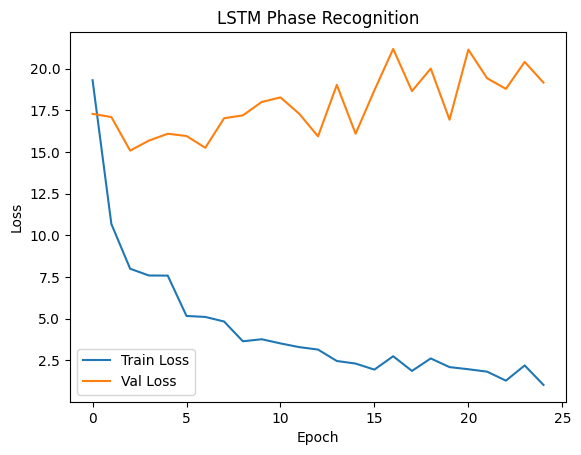

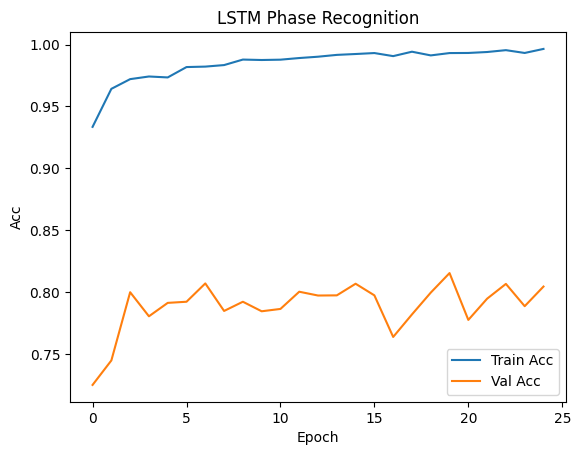

In [16]:
# plot
lstm_data = pd.read_csv(project_path+'/two_networks_two_tasks/log/lstm_phase_recognition.csv')
#lstm_data = pd.read_csv(project_path+'/two_networks_two_tasks/log-0/lstm_phase_recognition.csv')
train_loss = lstm_data['Train Loss'].values
val_loss = lstm_data['Val Loss'].values
plt.plot(range(len(train_loss)),train_loss)
plt.plot(range(len(val_loss)),val_loss)
plt.legend(['Train Loss','Val Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LSTM Phase Recognition')
plt.show()
train_acc = lstm_data['Train Acc'].values
val_acc = lstm_data['Val Acc'].values
plt.plot(range(len(train_acc)), train_acc)
plt.plot(range(len(val_acc)), val_acc)
plt.legend(['Train Acc', 'Val Acc'])
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('LSTM Phase Recognition')
plt.show()

In [17]:
# test
phase_rec_acc_list = []
model = LSTM()
model.load_state_dict(torch.load(project_path+'/two_networks_two_tasks/log/lstm.pkl'))
#model.load_state_dict(torch.load(project_path+'/two_networks_two_tasks/log-0/lstm.pkl'))
model.cuda()
model.eval()

for data in tqdm(test_loader):
  inputs, _, labels = data
  inputs = Variable(inputs.cuda())
  labels = Variable(labels.cuda())

  output = model(inputs)
  _, preds = torch.max(output, 1)

  # acc
  acc = torch.sum(preds == labels).float() / len(labels)
  phase_rec_acc_list.append(acc.data.cpu().numpy())
print('Phase Recognition Test Acc:{:.4f}'.format(np.mean(phase_rec_acc_list)))

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 4910/4910 [01:27<00:00, 55.93it/s]

Phase Recognition Test Acc:0.7446
